In [1]:
# Bunch of imports 
import therpy as tp
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
%matplotlib inline
import pandas as pd
import bec1db as bec1db_package
import warnings
from tqdm import tqdm_notebook as tqdm
warnings.filterwarnings("ignore")
import scipy.special
import os.path
import pickle
import ipywidgets as widgets
from IPython.display import display
import ipywidgets

cst = tp.cst(sigmaf=0.5)
kHz = cst.h * 1e3
twopi = np.pi * 2
bec1db = bec1db_package.Tullia(delta=20)

The servers are not connected!
Using the local database copy. Could be outdated!


In [2]:
# Bunch of functions 

def lorentzian_fitfun(f, f0, gamma, amp=1, offset=0):
    return amp * (gamma/2)**2 / ((f-f0)**2 + (gamma/2)**2) + offset

def gaussian(x, x0, sigma, amp, offset=0): return offset + amp*np.exp(- (x-x0)**2 / (2*sigma**2))

def bin_data(xi, yi):
    x = np.unique(xi)
    y = [None] * x.size
    for i in range(x.size): y[i] = yi[xi == x[i]]
    # Return 
    y_mean = np.array([a.mean() for a in y])
    y_err = np.array([np.std(a) / (a.size**0.5) for a in y])
    return (x, y_mean, y_err, y, xi, yi)

# returns rabi in kHz
@np.vectorize
def volt2rabi(volt):
    if volt < 0.1 or volt > 5:
        return 0
    volt = np.log10(volt)
    dbm = 1.5863 +0.2211*volt -0.1022*volt**2 -0.1301*volt**3 -0.0862*volt**4 +0.2323*volt**5 +0.1624*volt**6 -0.1552*volt**7 -0.1206*volt**8
    dbm = 10**dbm
    sqrtpwr = (10**((dbm-30)/10))**(1/2)
    return -0.0332 +0.5832*sqrtpwr -0.0167*sqrtpwr**2

from scipy.optimize import brentq
# Provide rabi in kHz
@np.vectorize
def rabi2volt(rabi):
    if rabi <= volt2rabi(0.1) or rabi >= volt2rabi(5):
        print('outside valid range')
        return 0
    def funSolve(v):
        return rabi - volt2rabi(v)
    return brentq(funSolve, 0.1, 5)
def meshgrid(xLen=10, yLen=10, data=None):
    if data is not None: yLen, xLen = data.shape
    return np.meshgrid(np.arange(xLen, dtype=np.float), np.arange(yLen, dtype=np.float))
def gaussian_2d(x, y, cx=1, cy=1, sx=1, sy=1, amp=1, offset=0, angle=0):
    x, y = x - cx, y - cy
    sx, sy = 2*sx**2, 2*sy**2
    a = angle * np.pi / 180
    xp, yp = x*np.cos(a) + y*np.sin(a), - x*np.sin(a) + y*np.cos(a)
    return offset + amp * np.exp(-xp**2/sx - yp**2/sy)
    
def gaussian_2d_guess(data, x=None, y=None):
    if x is None: x, y = np.meshgrid(np.arange(data.shape[1]), np.arange(data.shape[0]))
    t = np.sum(data)
    cx, cy = np.sum(data * x) / t, np.sum(data * y) / t
    sx, sy = (np.sum(data * (x-cx)**2) / t)**(1/2), (np.sum(data * (y-cy)**2) / t)**(1/2)
    return (cx, cy, sx, sy, data[int(cy), int(cx)], np.mean(data)/5, 0.0)
    
def fit_gaussian_2d(data, guess=None, plot=False):
    if guess is None: guess = gaussian_2d_guess(data)
    fr = tp.optimize.surface_fit(data, fun=gaussian_2d, guess=guess, show=plot)
    return fr
def gaussian_2d_integral(data, nsigma, fr=None, ideal=False, plot=False, guess=None, return_mask=False):
    if fr is None: fr = fit_gaussian_2d(data, guess=guess)
    # Generate the fitted data
    x, y = meshgrid(data=data)
    fit_data = gaussian_2d(x, y, *fr)
    amp = 1 if len(fr) <= 4 else fr[4]
    offset = 0 if len(fr) <= 5 else fr[5]
    # Ideal case
    if ideal:
        return np.sum(fit_data - offset)
    # Data case
    threshhold = np.exp(- nsigma**2/2) * amp + offset
    mask = fit_data >= threshhold
    # Plot
    if plot:
        plt.figure()
        plt.imshow(data)
        fit_data[~mask] = 0
        plt.imshow(mask, alpha=0.2, cmap='gray')
    
    # Mask return
    if return_mask:
        return mask
    
    return np.sum(data[mask])

''' 
Copy image names from clipboard and get parameters 
df : if you want to add on to the older df
init : initialize and return empty df
var : list of strings (variable names) that you want to retrive from database
x_var : a string (variable name), available as df.x
image_func : either tp.Image or tp.Hybrid_Image
using : 0=TopA only, 1=TopB only, 2=All Images
'''
def get_from_clipboard(df=None, init=False, var=None, x_var=None, image_func=tp.Image, using=2, display=False):
    # If initializing, then return empty dataframe
    if init: return pd.DataFrame(columns=['name','image'])
    
    # If df is None, make an empty one
    if df is None: 
        df = pd.DataFrame(columns=['name','image'])
    
    # Get the copied image names
    pasted = pd.read_clipboard(header=None, names=['name'])['name'].tolist()
    
    # Filter for using 0:TopA only, 1:TopB only, 2:all
    if using==0:
        pasted_filtered = [p for p in pasted if p[-1]=='A']
    elif using==1:
        pasted_filtered = [p for p in pasted if p[-1]=='B']
    else:
        pasted_filtered = [p for p in pasted]
    
    # Add it to df if not already in there
    names = df.name.tolist()
    for n in tqdm(pasted_filtered, desc='Loading'):
        if n not in names:
            df.loc[df.shape[0]] = n
            df.image[df.shape[0]-1] = image_func(name=n)
    
    # sort in time
    df.sort_values('name', inplace=True)
    df.reset_index(drop=True, inplace=True)
    
    # Get Parameters
    try: bec1db.refresh()
    except: pass
    df['shot'] = np.linspace(0,df.shape[0]/2-0.5,df.shape[0])
    if x_var is not None:
        df['x'] = bec1db.image_query(df.name.tolist(), [x_var])[x_var]
    if type(var) is str:
        df[var] = bec1db.image_query(df.name.tolist(), [var])[var]
    elif type(var) is list:
        _ = bec1db.image_query(df.name.tolist(), var)
        for n in var:
            df[n] = _[n]
    
    # Print Information
    if display:
        print('Pasted Sample : ', pasted[0:2])  
        print('Newly added images       : {}'.format(df.shape[0]- len(names)))
        print('Total number of images   : {}'.format(df.shape[0]))
    
    # return
    return df


def get_roi(data, center=[0,0], width=100, height=100):
    center = (data.shape[1]//2 + center[0], data.shape[0]//2 + center[1])
    return tp.imagedata.get_cropi(data, center=center, width=width, height=height)

def atom_num_filter(df_, keep = 0.15, offset = 0.0, plot=True):
    # Prepare
    if plot: fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(12,4))
    if plot: ax[0].plot(df_['shot'], df_['total_atoms']/1e6,'.-', label='All')
    shapes = [df_.shape]
    
    # Filter
    median_numbers = np.median(df_.total_atoms)
    offset += 1
    using = (df_.total_atoms.values > median_numbers*(offset-keep)) & (df_.total_atoms.values <= median_numbers*(offset+keep))
    bad = df_[~using] 
    df_ = df_[using]
    df_.reset_index(inplace=True, drop=True)
    shapes.append(df_.shape)
    if plot: ax[0].plot(bad['shot'], bad['total_atoms']/1e6, 'rx', label='Atom Num Filter')
    if plot: ax[0].axhline(median_numbers/1e6, linestyle='--', color='k', alpha=0.5)

    if plot: 
        # Plot
        median_numbers = np.median(df_.total_atoms)
        ax[1].plot(df_['shot'], df_['total_atoms']/median_numbers,'o-')
        ax[1].axhline(1, linestyle='--', color='k', alpha=0.5)

        ax[0].legend()
        ax[0].set(title = 'Atom number stability', xlabel= 'Shot Number ~ Time', ylabel='Atom Numbers [M]')
        ax[1].set(title = 'Median Atom Num {:.2f} M'.format(median_numbers/1e6), xlabel= 'Shot Number ~ Time', ylabel='Atom Numbers [median]')
        plt.tight_layout()

        # Relevant Information
        print('''
        Total Loaded Images {}
        Atom Num Filter     {}
        Removed Images      {}
        '''.format(shapes[0][0], shapes[1][0], shapes[0][0]-shapes[1][0]))
    
    return using

def erf(x, x0, sigma, amp=1):
    return amp * scipy.special.erf((x-x0)/(2**0.5 * sigma))

def mesh_for_2d_plot(x, y, z):
    x1 = np.concatenate([ [2*x[0] - x[1]], x])
    x2 = np.concatenate([x, [2*x[-1] - x[-2]]])
    x = np.mean([x1, x2], axis=0)

    y1 = np.concatenate([ [2*y[0] - y[1]], y])
    y2 = np.concatenate([y, [2*y[-1] - y[-2]]])
    y = np.mean([y1, y2], axis=0)
    
    return (x, y, z)

def fourier_transform(curve, k):
    return np.array([np.trapz(curve.y * np.exp(-1j * ki * curve.x) , curve.x) for ki in k])

'''
Least square curve fitting to {x,y} data 
========================================
Inputs Required : 
    fitfun - python function with inputs (of type x_data, p0, p1, p2, p3, ...) and returns np.array y_data 
    guess  - could be a simple list, or more detailed dict (see below for more info) 
    x_data - I think this could be anything supported by fitfun input, to be safe, keep it np.array 
    y_data - must be np.array 
    
Inputs Optional : 
    y_err - sigma for the y_data, defaults to np.ones_like(y_data). The following is optimized sum ( (y_data-fitfun(...))/y_err )^2
    fixed - dict(gradient = 0, tau = 5, ...) : parameters to fix. NOTE: if guess contains the same key, that key will not be fixed 
    plot  - True / False : Plots a standard figure with data, fit line, residuals 
    info  - True / False : prints fit results 

guess : recommended the third option 
    1) guess = [12, 3, -np.pi, ...] : a simple list 
    2) guess = [ [12, (10, 14), 'meter'], 3, [np.pi, (0, 2*np.pi)], ...] : mixture of simple value and fancy list 
    A fancy list for a guess contains up to three items -- the guess value itself, a tuple for lower and upper bounds, a string for units
    A fancy list must contain the guess itself, but the other two things are optional 
    3) guess = dict(tau = 12, phase = [np.pi, (0, 2*np.pi), 'radians'], ...) : a dictionary containing mixture of simple value and fancy list 

MUST DO : 
    - Make sure x_data, y_data, and y_err is valid for fitfun input/output and DOES NOT contain inf or nan. 

Properties : 
    fitresults : pandas dataframe of the fitresults 
    fitvalues : dict of fit values with parameters as keys, including the fixed and default parameters
    fiterrors : dict of fit errors with parameters as keys, including the fixed and default parameters
    fv : list of fit values, including the fixed and default parameters
    fe : list of fit errors, including the fixed and default parameters
    xp : finely spaced grid for same x range : np.linspace(self.x.min(), self.x.max(), 1000)
    
Special Methods : 
    __call__ : returns fitted curve at optionally provided x and overridden parameters : self(), self(x, phase=0, amp=0, ...), self(self.xp), 
    __len__ : len(self) returns the number of parameters the fitfun takes 
    __getitem__ : self['amp'] or self[1] : returns the fir value for given key or index 
    __setitem__ : self['amp'] = 0 or self[1] = 0 : fixes the 
    __bool__ : if self: or bool(self) : true if the fit was successful 
    __repr__ or __str__ : str(self) or print(self) : returns the fitresults in printable format 

Methods : 
    plot()
        two plots, data and fit curve on top, and residuals below. Optional inputs 
        ax : to plot somewhere specific
        fiterrors = False : include fit error band along with optimal fit 
        using = [] : which parameters to sue to calculate fiterrors band 
        divider = 0.25 : how to split the axes for residuals 
    plot_fitdata(ax=None) : data and fit curve 
    plot_residuals(ax=None) : residuals 
    plot_residuals_hist(ax=None, orientation='vertical) : histogram of the residuals 
    plot_fiterrors(ax=None, using=[]) : fit error band, optinally include only keys in using 
'''
import scipy.optimize

class Curve_Fit: 
    def __init__(self, fitfun, guess, x_data, y_data, y_err=None, fixed=dict(), plot=False, info=False): 
        ### Verify inputs 
        if not callable(fitfun): print("provided fitfun is not valid python function!")
        
        ### Process single item from guess -- return guess value, bounds, units 
        def temp_process_guess_item(item):
            units, bounds = None, [-np.inf, np.inf] # default value
            if type(item) in [list, tuple, np.ndarray]:
                value = item[0]
                if len(item) > 3: return [value, bounds, units]
                for i in item[1:]:
                    if type(i) is str: units = i
                    elif type(i) in [list, tuple, np.ndarray]: bounds = i
            else: value = item
            return [value, bounds, units]
        
        ### Process guess -- generate guess_keys, guess_values, guess_bounds, guess_units 
        # the order of keys will be determined by the order of fitfun input order 
        if type(guess) == dict:
            guess_keys = [k for k in fitfun.__code__.co_varnames[1:] if k in list(guess.keys())]
            temp_ = [temp_process_guess_item(guess[k]) for k in guess_keys]
        elif type(guess) in [list, tuple, np.ndarray]:
            guess_keys = fitfun.__code__.co_varnames[1:1+len(guess)]
            temp_ = [temp_process_guess_item(i) for i in guess]
        elif (type(guess) in [float, int]) or (np.issubdtype(guess, np.number)):
            guess_keys = fitfun.__code__.co_varnames[1:2]
            temp_ = [temp_process_guess_item(guess)]
        else:
            print('Does NOT understand data type of guess : ', guess)
        guess_values, guess_bounds, guess_units = np.array([i[0] for i in temp_]), np.array([i[1] for i in temp_]).T, [i[2] for i in temp_]
        
        ### Extract all fixed items, including provided and default ones
        fixed_func_defaults = {k:v for k, v in zip(fitfun.__code__.co_varnames[-len(fitfun.__defaults__):], fitfun.__defaults__)}
        fixed_dict = {**fixed_func_defaults, **fixed}
        for k in guess_keys: fixed_dict.pop(k, None)
        
        ### Define temp fitfun for internal use only 
        def fitfun_args(x, *args):
            return fitfun(x, **{k: v for k, v in zip(guess_keys, args)}, **fixed_dict)
        
        ### Fit Data 
        success = False
        try:
            fv_, fe_ = scipy.optimize.curve_fit(fitfun_args, x_data, y_data, guess_values, sigma=y_err, bounds=guess_bounds)
            fe_ = np.sqrt(np.diag(fe_))
            success = True
        except (ValueError, RuntimeError) as err: 
            fv_, fe_ = guess_values, guess_values*np.nan
            print("CAN'T FIT, Returning Original Guess: Details of Error :: {}".format(err))
            
        ### Formatting Fit Results 
        fitresults_dict = dict(FitValue=fv_, FitError=fe_, Units=guess_units, Guess=guess_values, LowerBound=guess_bounds[0], UpperBound=guess_bounds[1])
        fitresults_df = pd.DataFrame(fitresults_dict, index=guess_keys, columns=['FitValue','FitError','Units','Guess','LowerBound','UpperBound'])
        for k, v in fixed_dict.items(): fitresults_df.loc[k] = [v, 0, None, v, v, v]
        fitresults_df = fitresults_df.loc[fitfun.__code__.co_varnames[1:], :] # sort the index by function input list 
        fitresults_df['FitError%'] = np.nan_to_num(np.abs(fitresults_df['FitError'] / fitresults_df['FitValue'])) * 100
        
        ### Store results to self
        self.fitresults = fitresults_df
        self.fitfun = fitfun
        self.success = success
        self.x = x_data
        self.y = y_data
        self.y_err = y_err
        
        ### Plots and display 
        if plot: self.plot()
        if info: print(self)
    
    @property
    def fitvalues(self): return dict(self.fitresults['FitValue'])
    @property
    def fiterrors(self): return dict(self.fitresults['FitError'])
    @property
    def fv(self): return self.fitresults['FitValue'].values
    @property
    def fe(self): return self.fitresults['FitError'].values
    @property
    def xp(self): return np.linspace(self.x.min(), self.x.max(), 1000)
    
    def __call__(self, *args, **kwargs): 
        x = args[0] if len(args) == 1 else self.x
        return self.fitfun(x, **{**self.fitvalues, **kwargs})
    def __len__(self): return len(self.fv)
    def __getitem__(self, key): 
        if (type(key) in [int, float]): return self.fv[int(key)]
        elif type(key) == str: return self.fitvalues.get(key, None)
    def __setitem__(self, key, value): 
        if type(key) in [int, float]: key = self.fitresults.index.values[int(key)]
        r = self.fitresults.loc[key].values
        r[0], r[1], r[6] = value, 0, 0
        self.fitresults.loc[key] = r
    def __bool__(self): return self.success
    def __repr__(self): return self.fitresults.to_string()
    def __str__(self): return self.fitresults.to_string()
    
    def plot_fitdata(self, ax=None):
        if ax is None: fig, ax = plt.subplots()
        ax.errorbar(self.x, self.y, self.y_err, fmt='r.')
        ax.plot(self.xp, self(self.xp), 'k')
        return ax
    def plot_residuals(self, ax=None):
        if ax is None: fig, ax = plt.subplots()
        ax.axhline(0, c='k', alpha=0.5)
        ax.vlines(self.x, self.x*0, self.y-self())
        ax.plot(self.x, self.y-self(), 'r.')
        return ax
    def plot_residuals_hist(self, ax=None, orientation='vertical'):
        if ax is None: fig, ax = plt.subplots()
        ax.hist(self.y-self(), orientation=orientation)
        return ax
    def plot_fiterrors(self, ax=None, using=[]):
        ax = self.plot_fitdata(ax)
        xp = self.xp
        if type(using) == str: using = [using,]
        if len(using) == 0: using = self.fitresults.index.values
        ys = [self(xp)]
        for k in using:
            ys.append(self(xp, **{k : self.fitvalues[k] - self.fiterrors[k]}))
            ys.append(self(xp, **{k : self.fitvalues[k] + self.fiterrors[k]}))
        ax.fill_between(xp, np.min(ys, axis=0), np.max(ys, axis=0), color='g', alpha=0.25)
        return ax
    def plot(self, ax=None, fiterrors=False, using=[], divider=0.25):
        if ax is None: ax = plt.subplots(figsize=[5,5])[1]
        (ax1, ax2) = divide_axes(ax, divider=divider, direction='vertical', shared=True)
        if fiterrors: self.plot_fiterrors(ax1, using=using)
        else: self.plot_fitdata(ax1)
        self.plot_residuals(ax2)
        return (ax1, ax2)

# Additional Functions useful for general matplotlib axes creation 
'''
Adds a subplot inside a given axes 
==================================
Inputs -- all dimensions are in fractional sizes relative to the axes 
    ax : main axes 
    origin : location of the left bottom corner for the added subplot  
    width, height : width and height of the subplot 

Inputs Optional 
    bg = 'w' : the color for the background of the subplot, can't be transparent, because needs to cover the background 
    remove = False : remove the x,y-axis information from the parent axes 

Returns axes object of the subplot 
'''
def add_subplot_axes(ax, origin=[0.5,0.25], width=0.5, height=0.3, bg='w', remove=False):
    fig = ax.figure
    inax_position  = ax.transAxes.transform(origin)
    x, y = fig.transFigure.inverted().transform(inax_position)
    subax = fig.add_axes([x,y,ax.get_position().width*width,ax.get_position().height*height],facecolor=bg)
    if remove: ax.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
    return subax


'''
Divide an axes into two, horizontally or vertically 
===================================================
Inputs :
    ax : main axes 
    divider = 0.3 : fractional size for the bottom subplot 
    direction = 'vertical' : or 'horizontal' for division of the axes 
    shared = True : share the same x or y axis 

Returns (ax1, ax2) two subplot axes objects 
'''
def divide_axes(ax, divider=0.3, direction='vertical', shared=True):
    # Fractional Dimension for new axes  ; [origin_x, origin_y, width, height]
    if direction == 'horizontal':
        dim1 = [divider, 0, 1-divider, 1]
        dim2 = [0, 0, divider, 1]
    else:
        dim1 = [0, divider, 1, 1-divider]
        dim2 = [0, 0, 1, divider]
    # Add axes 
    ax1 = add_subplot_axes(ax, origin=dim1[0:2], width=dim1[2], height=dim1[3], bg='w', )
    ax2 = add_subplot_axes(ax, origin=dim2[0:2], width=dim2[2], height=dim2[3], bg='w', remove=True)
    # Adjust ticks for top (right) axes
    if direction == 'horizontal':
        ax1.tick_params(axis='y', which='both', direction='in', labelbottom=False, right=True)
        ax2.tick_params(axis='y', which='both', direction='in', right=True)
        if shared: ax1.get_shared_y_axes().join(ax1, ax2)
    else:
        ax1.tick_params(axis='x', which='both', direction='in', labelbottom=False, top=True)
        ax2.tick_params(axis='x', which='both', direction='in', top=True)
        if shared: ax1.get_shared_x_axes().join(ax1, ax2)
    # return
    return (ax1, ax2)

def makeplot_atomnum_time(ax, df_all, df=None, keep=None):
    if df is None: df = df_all
    if keep is None: 
        keep = (df.total_atoms.max() - df.total_atoms.mean()) / df.total_atoms.mean()
        keep = max(keep, (df.total_atoms.mean() - df.total_atoms.min()) / df.total_atoms.mean())
    using = np.array([i in df.index.values for i in df_all.index.values])
    ax.plot(df_all.shot, df_all.total_atoms/1e6, 'C0.-', 
            df_all[~using].shot, df_all[~using].total_atoms/1e6, 'rx')
    median_atom_num = np.median(df_all.total_atoms) / 1e6
    ax.axhline(median_atom_num, linestyle='-', c='k', alpha=0.5)
    ax.set(xlabel='Shot Number ~ Time', ylabel='Atom Number [Million]')
    ax.axhline(median_atom_num * (1 + keep), linestyle='--', c='k', alpha=0.5)
    ax.axhline(median_atom_num * (1 - keep), linestyle='--', c='k', alpha=0.5)
    ax.set(title='Fudge {}; Atom Num $\pm$ {:.0f}%;'.format(df.image.iloc[0].fudge, keep*100))
    

def makeplot_atomnum_hist(ax, df):
    ax.hist(df.total_atoms/1e6)
    mean_atom_num = np.mean(df.total_atoms)/1e6
    std_atom_num = np.std(df.total_atoms)/1e6
    ax.axvline(mean_atom_num, linestyle='-', c='k', alpha=0.5)
    ax.axvline(mean_atom_num + std_atom_num, linestyle='--', c='k', alpha=0.5)
    ax.axvline(mean_atom_num - std_atom_num, linestyle='--', c='k', alpha=0.5)
    ax.set(xlabel='Atom Number [Million]', ylabel='Histogram', title='Atom # {:.2f} $\pm$ {:.2f} M'.format(mean_atom_num, std_atom_num))

In [11]:
# Inport Dataset Information 
dataset_filename = 'Filenames.xlsx'
dataset_all_info = pd.read_excel(dataset_filename, sheetname=None)
dataset_all_keys = list(dataset_all_info.keys())
dataset_all = {}
print(dataset_all_keys)

['IS1', 'IS2', 'IS3', 'IS4', 'IS5', 'IS6']


In [16]:
# Constants 
import_vars = ['ExpansionTime','SideGreenEvap','WaitBox',
               'IREvap','HeatTime','ShakeWait', 'HeatCycles',
               'ShakingCycles', 'BoxShakeFreq','BoxShakeAmp','BoxShakeTime',
               'SeqMode','unixtime']

x_var_name = 'ShakeWait'

background_variable = 'ShakingCycles'
background_value = 0
threshold_image_num = 1

default_settings = dict(
   # Image Preparation and Background 
   center_x=1110, center_y=1314, width=800, height=800, 
   subsample=3, rotate=0, bg_width=20, bg_order=1, bad_light=0,

   # Physical Parameters
   Isat=77, time=10, pixel=0.7e-6, sigmaf=0.5, trap_f=23.9,
   od_method='table', fudge=1, ellipticity=1,
   
   # Hybrid Preparation
   xsec_extension='default', xsec_slice_width=4, 
   xsec_fit_range=1.75, radial_selection=0.5,
   
   # Hybrid Thermometry
   kind='unitary', Tfit_lim=0.06, Tfit_guess_kT=3, Tfit_guess_mu0=0, 
   
   # Other
   memory_saver=True, )

fontsize = 15

# Sonogram Analyzer Class 

## Define functions 

In [17]:
# Function Definitions 
def calculate_data_same_bg_center(df):
    # Count number of images 
    unique_x = np.unique(df.x)
    data_counts = np.array([np.sum(df.x[df[background_variable] != background_value].values == x) for x in unique_x])
    background_counts = np.array([np.sum(df.x[df[background_variable] == background_value].values == x) for x in unique_x])
    dataset_counter = [unique_x, data_counts, background_counts]

    # Fitting erf to get center and box length 
    guess = [-50e-6, 50e-6, 5e-6, 5e-6, 0.6e18, 1e15, ]
    def fitfun_erf_2(x, x1, x2, s1, s2, amp=1, offset=0, slope=0):
        y = erf(x, x1, s1) + erf(-x, -x2, s2)
        return y*amp/2 + offset + slope*x
    df['fitres_erf'] = [nz.fit(fitfun_erf_2, guess)[0] for nz in df.nz_raw]

    # Get the background profile 
    bg_ind = (df[background_variable] == background_value)
    length = np.mean([fr[1] - fr[0] for fr in df.fitres_erf[bg_ind]])
    amp = np.mean([fr[4] for fr in df.fitres_erf])
    nz_bg_all = [tp.Curve(r.nz_raw.x - (r.fitres_erf[0] + r.fitres_erf[1])/2 + length/2, 
        (r.nz_raw.y - r.fitres_erf[5]) * amp / r.fitres_erf[4]) for i, r in df[bg_ind].iterrows()]
    nz_bg_concat = tp.Curve(np.concatenate([nz.x for nz in nz_bg_all]), np.concatenate([nz.y for nz in nz_bg_all])).sortbyx()
    nz_bg = nz_bg_concat.binbyx(step = np.diff(df.iloc[0].nz_raw.x)[0])

    # Process particular x 
    def process_particular_x(x, ):
        # collect bg and data ind for this x 
        data_ind = (df[background_variable] != background_value) & (df.x == x)

        # compute parameters 
        freq = np.unique(df.BoxShakeFreq[data_ind])[0]
        cycles = np.unique(df.ShakingCycles[data_ind])[0]

        # Get all nz
        nz_data_all = [tp.Curve(r.nz_raw.x - (r.fitres_erf[0] + r.fitres_erf[1])/2 + length/2, 
                 (r.nz_raw.y - r.fitres_erf[5]) * amp / r.fitres_erf[4]) for i, r in df[data_ind].iterrows()]

        # Average nz 
        nz_data_concat = tp.Curve(np.concatenate([nz.x for nz in nz_data_all]), np.concatenate([nz.y for nz in nz_data_all])).sortbyx()
        nz_data = nz_data_concat.binbyx(step = np.diff(df.iloc[0].nz_raw.x)[0])

        # compute delta rho 
        x = nz_bg.x.copy()
        delta_rho = tp.Curve(x, nz_data(x) - nz_bg(x))
        delta_rho_rho = tp.Curve(x, (nz_data(x) - nz_bg(x))/nz_bg(x) )

        # return 
        return (delta_rho, delta_rho_rho, nz_data, nz_bg, nz_data_all, 
                nz_bg_all, data_ind, bg_ind, 
                length, amp, np.sum(data_ind), np.sum(bg_ind), freq, cycles)
    

    # df_data 
    df_data = pd.DataFrame(columns=['Delta rho', 'Delta rho / rho', 'nz data', 
                                    'nz bg', 'nz data all', 'nz bg all', 'data_ind', 'bg_ind', 
                                    'length', 'amp', '# data', '# bg', 'freq', 'cycles'])
    for i, x in enumerate(dataset_counter[0]):
        if (dataset_counter[1][i] >= threshold_image_num):
            df_data.loc[x] = process_particular_x(x)
    
    return df_data

def calculate_shifted_app_center(df, df_data): 
    # Compute x, y origin for all images 
    def get_origin_pixel(r):
        # Get the index of the right edge of the box == this is the y origin 
        use_center = (r.fitres_erf[0] + r.fitres_erf[1])/2
        y = tp.Curve((r.nz_raw.x - use_center) * 1e6, np.arange(len(r.nz_raw.x)))(0)
        # Get the center from xsec at that y pixel 
        x = tp.Curve(np.arange(len(r.image.xsec.center)), r.image.xsec.center)(y)
        return [x, y]
    origin = np.array([get_origin_pixel(r) for i,r in df.iterrows()])
    df['origin_x'], df['origin_y'] = origin[:,0], origin[:,1]
    
    # define grid based on average origin 
    r = df.iloc[0]
    x = np.arange(r.image.app.shape[1]) - np.mean(df.origin_x)
    y = np.arange(r.image.app.shape[0]) - np.mean(df.origin_y)
    xx, yy = np.meshgrid(x, y)

    # Function to compute app_shifted 
    import scipy.interpolate
    def compute_app_shifted(r):
        x_ = np.arange(r.image.app.shape[1]) - r.origin_x
        y_ = np.arange(r.image.app.shape[0]) - r.origin_y
        interp = scipy.interpolate.interp2d(x_, y_, r.image.app, kind='linear')
        return interp(x, y)
    
    # compute shifted app for all images 
    df['app_shifted'] = [compute_app_shifted(r) for i,r in df.iterrows()]
    
    # Add shifted app to the df_data 
    df_data['2D Delta rho'] = None
    for x, r in df_data.iterrows():
        bg_mean = np.mean([a/np.mean(a) for a in df[r.bg_ind].app_shifted], axis = 0)
        data_mean = np.mean([a/np.mean(a) for a in df[r.data_ind].app_shifted], axis=0)
        df_data['2D Delta rho'].loc[x] = data_mean - bg_mean


In [52]:
class sonogram_analyzer: 
    def __init__(self, dataset_key, image_settings=default_settings, select_image='A', keep_atoms=0.1, test=None):
        # Import and filter data 
        print('Acquiring Image Parameters ..... ')
        imagenames = dataset_all_info[dataset_key]['data'].tolist()
        if test is not None: imagenames = imagenames[-test:]
        imagenames = [n for n in imagenames if n[-1] == select_image]
        df_all = bec1db.image_query(imagenames, import_vars)
        df_all = df_all.set_index('unixtime').sort_index().rename(columns={'imagename':'name'})
        df_all['x'] = df_all[x_var_name]
        df_all['shot'] = (df_all.index.values - df_all.index.values[0]) / 60.0
        df_all['image'] = [tp.Hybrid_Image(n, **image_settings) for n in tqdm(df_all.name, desc='Loading',)]
        df_all['total_atoms'] = [im.total_atoms for im in tqdm(df_all.image, desc='Atom #')]
        using = atom_num_filter(df_all, keep=keep_atoms, offset=0.0, plot=False)
        df = df_all[using]
        
        # Computation 
        df['nz_raw'] = [im.nz for im in tqdm(df.image, desc='n(z)')]
        print('Computing Sonogram Data ..... ')
        df_data = calculate_data_same_bg_center(df)
        print('Computing 2D Sonogram Data ..... ')
        calculate_shifted_app_center(df, df_data)
        
        # Store results 
        self.df_all = df_all 
        self.df = df
        self.df_data = df_data
    
    def plot_basic_info(self, ):
        ax = plt.subplots(ncols=2, nrows=2, figsize=[8,8])[1].flatten()
        self.df.iloc[0].image.plot_crop(ax = ax[0:2])
        makeplot_atomnum_time(ax[2], df_all=self.df_all, df=self.df)
        makeplot_atomnum_hist(ax[3], df=self.df)
        plt.tight_layout()
        return ax

    def sonogram(self, use='Delta rho', z_lim = [-15, 110]):
        z_lim = np.array(z_lim) * 1e-6
        movie = np.array([nz.trim(xlim=z_lim).y for nz in self.df_data[use]]).T
        return (self.df_data.index.values, self.df_data[use].iloc[0].trim(xlim=z_lim).x * 1e6, movie / np.mean(self.df_data.amp))
    
    def ft(self, sonogram, k_max = 14, k_step=0.2):
        L = np.mean(self.df_data.length) * 1e6
        k = np.arange(0, k_max * np.pi/L, k_step * np.pi / L)
        k_scale = np.pi/L
        movie_ft = np.array([np.abs(fourier_transform(tp.Curve(sonogram[1], sonogram[2][:, i].flatten()), k)) for i in range(len(sonogram[0]))]).T
        return [sonogram[0], k/k_scale, movie_ft]
    

## Load All Datasets 

Acquiring Image Parameters ..... 



Computing Sonogram Data ..... 
Computing 2D Sonogram Data ..... 


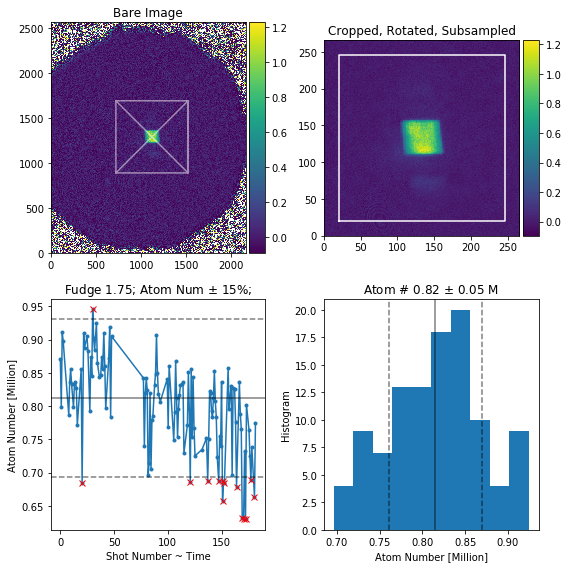

In [54]:
# Analyze Data 
ds = 'IS1'

settings = {**default_settings, 
            **dict(center_x = 1120, center_y = 1290, fudge=1.75,
                  xsec_extension='linear', xsec_slice_width=3, xsec_fit_range=1.0, radial_selection=0.8,)}

self = sonogram_analyzer(dataset_key=ds, image_settings=settings, select_image='A', keep_atoms=0.15,)
dataset_all[ds] = dict(self=self, )

ax = self.plot_basic_info()

Acquiring Image Parameters ..... 



Computing Sonogram Data ..... 
Computing 2D Sonogram Data ..... 


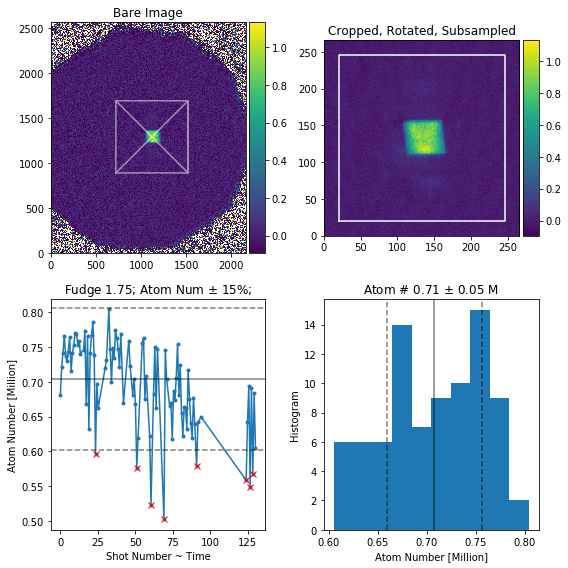

In [76]:
# Analyze Data 
ds = 'IS2'

settings = {**default_settings, 
            **dict(center_x = 1120, center_y = 1290, fudge=1.75, 
                  xsec_extension='linear', xsec_slice_width=3, xsec_fit_range=1.0, radial_selection=0.8,)}

self = sonogram_analyzer(dataset_key=ds, image_settings=settings, select_image='A', keep_atoms=0.15, )
dataset_all[ds] = dict(self=self, )

ax = self.plot_basic_info()

In [ ]:
# Analyze Data 
ds = 'IS3'

settings = {**default_settings, 
            **dict(center_x = 1187, center_y = 1370, fudge=1.75, 
                  xsec_extension='linear', xsec_slice_width=3, xsec_fit_range=1.0, radial_selection=0.8,)}

self = sonogram_analyzer(dataset_key=ds, image_settings=settings, select_image='A', keep_atoms=0.08, )
dataset_all[ds] = dict(self=self, )

ax = self.plot_basic_info()

In [ ]:
# Analyze Data 
ds = 'IS4'

settings = {**default_settings, 
            **dict(center_x = 1187, center_y = 1370, fudge=1.75, 
                  xsec_extension='linear', xsec_slice_width=3, xsec_fit_range=1.0, radial_selection=0.8,)}

self = sonogram_analyzer(dataset_key=ds, image_settings=settings, select_image='A', keep_atoms=0.08, )
dataset_all[ds] = dict(self=self, )

ax = self.plot_basic_info()

In [ ]:
# Analyze Data 
ds = 'IS5'

settings = {**default_settings, 
            **dict(center_x = 1187, center_y = 1370, fudge=1.75, 
                  xsec_extension='linear', xsec_slice_width=3, xsec_fit_range=1.0, radial_selection=0.8,)}

self = sonogram_analyzer(dataset_key=ds, image_settings=settings, select_image='A', keep_atoms=0.08, )
dataset_all[ds] = dict(self=self, )

ax = self.plot_basic_info()

In [ ]:
# Analyze Data 
ds = 'IS6'

settings = {**default_settings, 
            **dict(center_x = 1187, center_y = 1370, fudge=1.75, 
                  xsec_extension='linear', xsec_slice_width=3, xsec_fit_range=1.0, radial_selection=0.8,)}

self = sonogram_analyzer(dataset_key=ds, image_settings=settings, select_image='A', keep_atoms=0.08, )
dataset_all[ds] = dict(self=self, )

ax = self.plot_basic_info()

In [20]:
dataset_all['keys'] = [k for k in dataset_all_keys if k in dataset_all.keys()]

## Further Analysis

In [ ]:
# definitions 
def plot

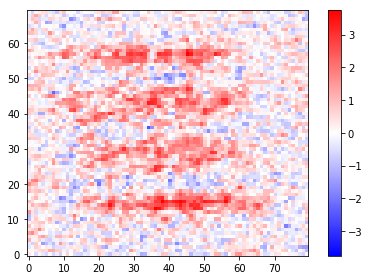

In [112]:
# Slider Viewer 
k = 'IS1'
use = '2D Delta rho'
cmap = 'bwr'
width=80
height=70
center = [3, 0]
clim = np.max(np.abs(movie.iloc[0])) * 1.
clim=[-clim, clim]


df_data = dataset_all[k]['self'].df_data
movie = df_data[use]
roi = get_roi(movie.iloc[0], width=80, height=70, center=center)
data_plot = movie.iloc[0][roi]
# data_plot = scipy.ndimage.filters.gaussian_filter(data_plot, sigma=0.8, order=0,)
plt.imshow(data_plot, origin=0, cmap=cmap, clim=clim)
plt.colorbar()
plt.tight_layout()

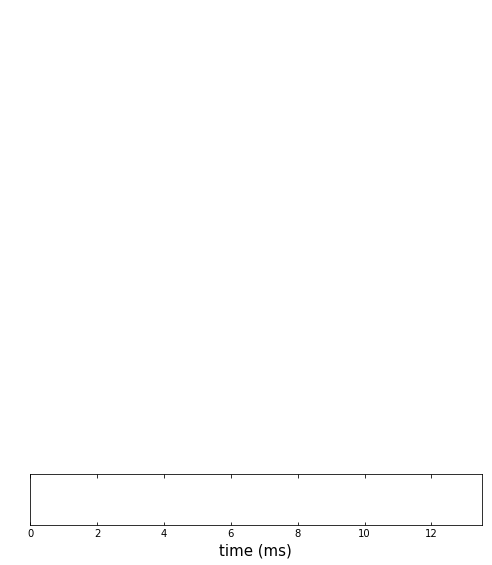

In [114]:
# Animation 

# Create list of artists for animation 
fig, ax = plt.subplots(figsize=[7, 8])
ax.set_xlabel('time (ms)', fontsize=15)
plt.tight_layout()
ax1, ax2 = divide_axes(ax, divider=0.1, shared=False)
ax.set_axis_off()
ax1.set_axis_off()
ax2.get_yaxis().set_visible(False)
ax2.set_xlabel('time (ms)', fontsize=15)
ax2.set_xlim([0, np.max(df_data.index.values)])

artists = []

for x in df_data.index.values:
    # Generate Data 
    data_plot = movie.loc[x][roi]
    data_plot = scipy.ndimage.filters.gaussian_filter(data_plot, sigma=0, order=0,)
    
    # Make plot 
    p1 = ax.imshow(data_plot, origin=0, cmap=cmap, clim=clim)
    p2 = ax2.axvline(x, c='k', linewidth=5)
    artists.append([p1,p2])

ani = animation.ArtistAnimation(fig, artists, interval=200, repeat_delay=0, repeat=True, )
ani.save('FreeDecay_{}_{}.gif'.format(k, cmap),  writer='imagemagick')
# HTML(ani.to_html5_video()) 